# BaseLine на логистической регрессии

In [1]:
import os
from dotenv import load_dotenv
import json
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.metrics import classification_report

In [2]:
load_dotenv()

True

In [3]:
DATA_DIR = os.getenv('DATA_DIR')
DATA_DIR

'data'

In [4]:
MODELS_DIR = os.getenv('MODELS_DIR')
MODELS_DIR

'models'

## Train Data

In [5]:
path_to_datafile = os.path.join(DATA_DIR, 'data_final_for_dls_new.jsonl')
data = pd.read_json(path_to_datafile, orient='orient', lines=True)[570:]
data = data[data['relevance_new'] != 0.1]
data

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance,reviews_summarized,relevance_new
570,налоговая 5007,"Московская область, Королёв, улица Богомолова, 4",Налоговая служба; Межрайонная ИФНС № 2; ИФНС №...,Налоговая инспекция,1377658436,None,0.0,Организация занимается обслуживанием налогопла...,0.0
571,шугаринг Красноярск,"Красноярск, микрорайон Взлётка, улица Весны, 3",Студия красоты Дарлинг; Darling; Дарлинг,Салон красоты,1085001465,Студия красоты «Дарлинг» предоставляет услуги ...,1.0,Студия красоты «Дарлинг» предоставляет бьюти-у...,1.0
573,новогодняя ночь 2018 в ресторане,"Москва, Кутузовский проспект, 36А",Atlantica seafood; Коллекция; Коллекция Food &...,Ресторан,1187477091,Ресторан Atlantica предлагает разнообразные бл...,1.0,Организация занимается ресторанным бизнесом и ...,1.0
574,балетная школа в санкт петербурге 12лет с прож...,"Санкт-Петербург, Невский проспект, 35В",Русская национальная балетная школа Илзе Лиепа...,Школа танцев,172170646460,None,0.0,Организация занимается обучением балету и хоре...,0.0
575,солкосерил гель цена,"Москва, Симферопольский бульвар, 29, корп. 1",Столички; Stolichki; Apteki Stolichki,Аптека,226500195223,Аптека «Столички» предлагает широкий спектр ле...,1.0,Организация занимается продажей лекарств и мед...,1.0
...,...,...,...,...,...,...,...,...,...
35089,нотариус запись,"Москва, 15-я Парковая улица, 45",Нотариус О. Н. Савина; Notarius O. N. Savina; ...,Нотариусы,1056199530,None,1.0,Организация предоставляет нотариальные услуги ...,1.0
35090,стационар для кота москва,"Москва, улица Госпитальный Вал, 3, корп. 5",ТриоВет; Triovet; Триовет; Veterinaria Triovet,Ветеринарная клиника,133156701339,"Ветеринарная клиника, аптека и лаборатория «Тр...",0.0,"Организация занимается ветеринарными услугами,...",0.0
35091,агзс пропан,"Самара, улица 22-го Партсъезда, 49, корп. 1",Роза Мира; АЗС № 2; Роза мира,АЗС,6884296946,None,0.0,Организация занимается заправкой транспортных ...,0.0
35092,где вибрить ваз 2112,"Нижний Новгород, Московское шоссе, 34","Нижегородец, Lada; Nizhegorodec, Lada; Нижегор...",Автосалон,124836381099,Автосалон «Нижегородец» предлагает новые автом...,0.0,Автосалон «Нижегородец» занимается продажей и ...,0.0


In [6]:
data = data.fillna("")

In [7]:
X = data.drop(columns=['relevance', 'relevance_new', 'address', 'permalink'])
X

,Text,name,normalized_main_rubric_name_ru,prices_summarized,reviews_summarized
570,налоговая 5007,Налоговая служба; Межрайонная ИФНС № 2; ИФНС №...,Налоговая инспекция,,Организация занимается обслуживанием налогопла...
571,шугаринг Красноярск,Студия красоты Дарлинг; Darling; Дарлинг,Салон красоты,Студия красоты «Дарлинг» предоставляет услуги ...,Студия красоты «Дарлинг» предоставляет бьюти-у...
573,новогодняя ночь 2018 в ресторане,Atlantica seafood; Коллекция; Коллекция Food &...,Ресторан,Ресторан Atlantica предлагает разнообразные бл...,Организация занимается ресторанным бизнесом и ...
574,балетная школа в санкт петербурге 12лет с прож...,Русская национальная балетная школа Илзе Лиепа...,Школа танцев,,Организация занимается обучением балету и хоре...
575,солкосерил гель цена,Столички; Stolichki; Apteki Stolichki,Аптека,Аптека «Столички» предлагает широкий спектр ле...,Организация занимается продажей лекарств и мед...
...,...,...,...,...,...
35089,нотариус запись,Нотариус О. Н. Савина; Notarius O. N. Savina; ...,Нотариусы,,Организация предоставляет нотариальные услуги ...
35090,стационар для кота москва,ТриоВет; Triovet; Триовет; Veterinaria Triovet,Ветеринарная клиника,"Ветеринарная клиника, аптека и лаборатория «Тр...","Организация занимается ветеринарными услугами,..."
35091,агзс пропан,Роза Мира; АЗС № 2; Роза мира,АЗС,,Организация занимается заправкой транспортных ...
35092,где вибрить ваз 2112,"Нижегородец, Lada; Nizhegorodec, Lada; Нижегор...",Автосалон,Автосалон «Нижегородец» предлагает новые автом...,Автосалон «Нижегородец» занимается продажей и ...


In [8]:
y = data['relevance_new']
y

570      0.0
571      1.0
573      1.0
574      0.0
575      1.0
        ... 
35089    1.0
35090    0.0
35091    0.0
35092    0.0
35093    0.0
Name: relevance_new, Length: 29891, dtype: float64

In [9]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

Не стал делить обучающую выборку на train и test, т.к. в данном слусчае это не имеет смысла поскольку есть валидационная выборка. Наоборот лучше увеличить обучающий датасет.

In [16]:
X_train = X
y_train = y

In [17]:
X_train

,Text,name,normalized_main_rubric_name_ru,prices_summarized,reviews_summarized
570,налоговая 5007,Налоговая служба; Межрайонная ИФНС № 2; ИФНС №...,Налоговая инспекция,,Организация занимается обслуживанием налогопла...
571,шугаринг Красноярск,Студия красоты Дарлинг; Darling; Дарлинг,Салон красоты,Студия красоты «Дарлинг» предоставляет услуги ...,Студия красоты «Дарлинг» предоставляет бьюти-у...
573,новогодняя ночь 2018 в ресторане,Atlantica seafood; Коллекция; Коллекция Food &...,Ресторан,Ресторан Atlantica предлагает разнообразные бл...,Организация занимается ресторанным бизнесом и ...
574,балетная школа в санкт петербурге 12лет с прож...,Русская национальная балетная школа Илзе Лиепа...,Школа танцев,,Организация занимается обучением балету и хоре...
575,солкосерил гель цена,Столички; Stolichki; Apteki Stolichki,Аптека,Аптека «Столички» предлагает широкий спектр ле...,Организация занимается продажей лекарств и мед...
...,...,...,...,...,...
35089,нотариус запись,Нотариус О. Н. Савина; Notarius O. N. Savina; ...,Нотариусы,,Организация предоставляет нотариальные услуги ...
35090,стационар для кота москва,ТриоВет; Triovet; Триовет; Veterinaria Triovet,Ветеринарная клиника,"Ветеринарная клиника, аптека и лаборатория «Тр...","Организация занимается ветеринарными услугами,..."
35091,агзс пропан,Роза Мира; АЗС № 2; Роза мира,АЗС,,Организация занимается заправкой транспортных ...
35092,где вибрить ваз 2112,"Нижегородец, Lada; Nizhegorodec, Lada; Нижегор...",Автосалон,Автосалон «Нижегородец» предлагает новые автом...,Автосалон «Нижегородец» занимается продажей и ...


In [18]:
y_train

570      0.0
571      1.0
573      1.0
574      0.0
575      1.0
        ... 
35089    1.0
35090    0.0
35091    0.0
35092    0.0
35093    0.0
Name: relevance_new, Length: 29891, dtype: float64

In [19]:
# X_test

In [20]:
# y_test

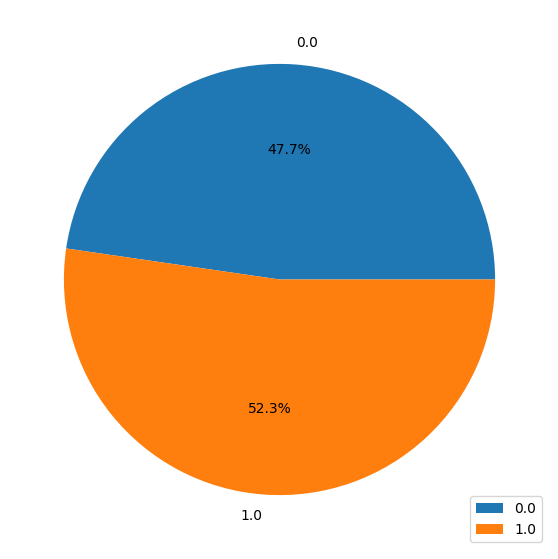

In [21]:
labels_counts = data.groupby('relevance_new').agg(count = ('relevance_new', 'count'))
labels_counts.plot.pie(figsize=(7, 7), subplots=True, autopct='%1.1f%%')
plt.ylabel('')
plt.legend(loc='lower right')
plt.show()

In [23]:
# Создаём преобразователь для текстовых признаков
preprocessor = ColumnTransformer(
    transformers=[
        (col, TfidfVectorizer(), col) for col in X_train
    ],
    remainder="drop"
)

In [24]:
pipe = Pipeline(
        [
            ("vectorizer", preprocessor),
            ("model", LogisticRegression(max_iter=1000, random_state=42)),
        ]
    )

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 ColumnTransformer(transformers=[('Text', TfidfVectorizer(),
                                                  'Text'),
                                                 ('name', TfidfVectorizer(),
                                                  'name'),
                                                 ('normalized_main_rubric_name_ru',
                                                  TfidfVectorizer(),
                                                  'normalized_main_rubric_name_ru'),
                                                 ('prices_summarized',
                                                  TfidfVectorizer(),
                                                  'prices_summarized'),
                                                 ('reviews_summarized',
                                                  TfidfVectorizer(),
                                                  'reviews_summarized')])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

## Сохранение модели

In [27]:
# save
path_to_model = os.path.join(MODELS_DIR, 'model_logreg.pkl')
with open(path_to_model,'wb') as f:
    pickle.dump(pipe,f)

In [28]:
# load
# with open('model_logreg.pkl', 'rb') as f:
#     model = pickle.load(f)

## Оценка касчества модели на тестовом датасете

In [25]:
# test_pred = pipe.predict(X_test)
# test_proba = pipe.predict_proba(X_test)
# test_acc = accuracy_score(y_test, test_pred)
# test_roc = roc_auc_score(y_test, test_proba[:, 1])
# test_logloss = log_loss(y_test, test_proba)
# print("Test Accuracy:", test_acc)
# print("Test ROC AUC:", test_roc)
# print("Test Log Loss:", test_logloss)

In [26]:
# Оценка
# print(classification_report(y_test, test_pred))

## Оценка качества модели на валидационном датасете

In [29]:
path_to_datafile = os.path.join(DATA_DIR, 'data_final_for_dls_eval_new.jsonl')
val_data = pd.read_json(path_to_datafile, orient='orient', lines=True)
val_data = val_data[val_data['relevance_new'] != 0.1]
val_data = val_data.fillna("")
val_data

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance,reviews_summarized,relevance_new
0,сигары,"Москва, Дубравная улица, 34/29",Tabaccos; Магазин Tabaccos; Табаккос,Магазин табака и курительных принадлежностей,1263329400,,1.0,"Организация занимается продажей табака, курите...",1.0
1,кальянная спб мероприятия,"Санкт-Петербург, Большой проспект Петроградско...",PioNero; Pionero; Пицца Паста бар; Pio Nero; P...,Кафе,228111266197,PioNero предлагает разнообразные блюда итальян...,0.0,"Организация PioNero — это кафе, бар и ресторан...",0.0
2,Эпиляция,"Московская область, Одинцово, улица Маршала Жу...",MaxiLife; Центр красоты и здоровья MaxiLife; Ц...,Стоматологическая клиника,1247255817,"Стоматологическая клиника, массажный салон и к...",1.0,"Организация занимается стоматологическими, кос...",1.0
4,стиральных машин,"Москва, улица Обручева, 34/63",М.Видео; M Video; M. Видео; M.Видео; Mvideo; М...,Магазин бытовой техники,1074529324,М.Видео предлагает широкий ассортимент бытовой...,1.0,Организация занимается продажей бытовой техник...,1.0
5,сеть быстрого питания,"Санкт-Петербург, 1-я Красноармейская улица, 15",Rostic's; KFC; Ресторан быстрого питания KFC,Быстрое питание,1219173871,Rostic's предлагает различные наборы быстрого ...,1.0,"Организация занимается быстрым питанием, предо...",1.0
...,...,...,...,...,...,...,...,...,...
561,наращивание ресниц,"Саратов, улица имени А.С. Пушкина, 1",Сила; Sila; Beauty brow; Студия бровей Beauty ...,Салон красоты,236976975812,Салон красоты «Сила» предлагает услуги по уход...,1.0,Организация «Сила» занимается предоставлением ...,1.0
565,игры,"Москва, Щёлковское шоссе, 79, корп. 1",YouPlay; YouPlay КиберКлуб,Компьютерный клуб,109673025161,YouPlay КиберКлуб предлагает услуги по игре на...,0.0,Организация занимается предоставлением услуг к...,0.0
566,домашний интернет в курске что подключить отзы...,"Курск, Садовая улица, 5",Цифровой канал; Digital Channel; DChannel; ЦК;...,Телекоммуникационная компания,1737991898,,0.0,,0.0
567,гостиница волгодонск сауна номер телефона,"Ростовская область, городской округ Волгодонск...",Поплавок; Poplavok,"База , дом отдыха",147783493467,"Предлагает размещение в различных типах жилья,...",0.0,Организация «Поплавок» предлагает услуги базы ...,0.0


In [30]:
X_val = val_data.drop(columns=['relevance', 'relevance_new', 'address', 'permalink'])
X_val

,Text,name,normalized_main_rubric_name_ru,prices_summarized,reviews_summarized
0,сигары,Tabaccos; Магазин Tabaccos; Табаккос,Магазин табака и курительных принадлежностей,,"Организация занимается продажей табака, курите..."
1,кальянная спб мероприятия,PioNero; Pionero; Пицца Паста бар; Pio Nero; P...,Кафе,PioNero предлагает разнообразные блюда итальян...,"Организация PioNero — это кафе, бар и ресторан..."
2,Эпиляция,MaxiLife; Центр красоты и здоровья MaxiLife; Ц...,Стоматологическая клиника,"Стоматологическая клиника, массажный салон и к...","Организация занимается стоматологическими, кос..."
4,стиральных машин,М.Видео; M Video; M. Видео; M.Видео; Mvideo; М...,Магазин бытовой техники,М.Видео предлагает широкий ассортимент бытовой...,Организация занимается продажей бытовой техник...
5,сеть быстрого питания,Rostic's; KFC; Ресторан быстрого питания KFC,Быстрое питание,Rostic's предлагает различные наборы быстрого ...,"Организация занимается быстрым питанием, предо..."
...,...,...,...,...,...
561,наращивание ресниц,Сила; Sila; Beauty brow; Студия бровей Beauty ...,Салон красоты,Салон красоты «Сила» предлагает услуги по уход...,Организация «Сила» занимается предоставлением ...
565,игры,YouPlay; YouPlay КиберКлуб,Компьютерный клуб,YouPlay КиберКлуб предлагает услуги по игре на...,Организация занимается предоставлением услуг к...
566,домашний интернет в курске что подключить отзы...,Цифровой канал; Digital Channel; DChannel; ЦК;...,Телекоммуникационная компания,,
567,гостиница волгодонск сауна номер телефона,Поплавок; Poplavok,"База , дом отдыха","Предлагает размещение в различных типах жилья,...",Организация «Поплавок» предлагает услуги базы ...


In [31]:
y_val = val_data['relevance_new']
y_val

0      1.0
1      0.0
2      1.0
4      1.0
5      1.0
      ... 
561    1.0
565    0.0
566    0.0
567    0.0
569    0.0
Name: relevance_new, Length: 500, dtype: float64

In [32]:
val_pred = pipe.predict(X_val)
val_proba = pipe.predict_proba(X_val)
val_acc = accuracy_score(y_val, val_pred)
val_roc = roc_auc_score(y_val, val_proba[:, 1])
val_logloss = log_loss(y_val, val_proba)
print("Val Accuracy:", val_acc)
print("Val ROC AUC:", val_roc)
print("Val Log Loss:", val_logloss)

Val Accuracy: 0.648
Val ROC AUC: 0.7100205133509162
Val Log Loss: 0.6589738482488864


In [33]:
print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.72      0.60       183
         1.0       0.79      0.61      0.69       317

    accuracy                           0.65       500
   macro avg       0.65      0.66      0.64       500
weighted avg       0.69      0.65      0.65       500

